In [1]:
__author__ = 'Monika Soraisam'
__email__ = 'monika.soraisam@noirlab.edu'

# GHOST standard resolution -- GS-2024A-Q-414-13

In [2]:
import os
from pathlib import Path
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime

# for bokeh apps to load from the jupyter notebook on a different browser tab
import nest_asyncio
nest_asyncio.apply()

In [3]:
# Now import the DRAGONS libraries 
import astrodata
import gemini_instruments
from recipe_system import cal_service
from gempy.adlibrary import dataselect
from gempy.utils import logutils

from recipe_system.reduction.coreReduce import Reduce
from gempy.scripts import showpars
from gempy.utils.showrecipes import showrecipes
from gempy.utils.showrecipes import showprims

In [4]:
## prep the reduction folder
def prep_reduction_folder(data_root, obsid):
    reduction_path = Path(f"{data_root}/{obsid}/reduction")

    if not reduction_path.exists():
        os.mkdir(reduction_path.as_posix())
        print (f"directory for dragons reduction created")
    
    ## change the cwd to the reduction folder
    os.chdir(reduction_path.as_posix())
    print(f"Current working directory is: {os.getcwd()}")

    ## write the configuration file 
    #mydb = "dragons_for_goats.db" 
    mydb = "dragons_for_goats2.db"     
    mydb_path = reduction_path.as_posix() + '/' + mydb
    print (mydb_path)
    
    dragons_rc = reduction_path.as_posix() + '/dragonsrc'
    print (dragons_rc)
    
    with open(dragons_rc, "w") as f:
        f.write("[calibs]\ndatabases = {0} get store".format(mydb_path))

    return dragons_rc, mydb_path


In [5]:
data_path = "/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost"
obsid = 'GS-2024A-Q-414-13'
dragons_rc, mydb_path = prep_reduction_folder(data_path, obsid)


Current working directory is: /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/dragons_for_goats2.db
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/dragonsrc


In [6]:
print(f"Confirming current working directory is: {os.getcwd()}")

Confirming current working directory is: /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction


In [7]:
# initialize the calibration database and complete the set-up 
caldb = cal_service.LocalDB(mydb_path, force_init=True) # 

## Note that for GHOST instrument, unlike other Gemini instruments, a raw fits file of a given observation type contains multiple exposures from the blue channel, red channel and slit-viewer camera "bundled" together -- i.e., as extensions of the same fits file. They need to be de-bundled before a recipe could be applied. For GOATS, it's best to de-bundle the files during the download process. Makre sure to delete the parent raw bundled fits files to save disk space.

### De-bundle the raw files -- note that for GHOST, files reduced by the NOIRLab/CSDC team are also hosted in the archive, which are downloaded together from GOA with the raw files. These reduced data are obviously de-bundled already.

2024-09-23 12:49:03 STDINFO  - All submitted files appear valid:
All submitted files appear valid:
2024-09-23 12:49:03 STDINFO  - /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240515S0042.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240515S0042.fits


S20240515S0042.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
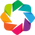

2024-09-23 12:49:07 STATUS   - ================================================================================
2024-09-23 12:49:07 STATUS   - RECIPE: processBundle
RECIPE: processBundle
2024-09-23 12:49:07 STATUS   - ================================================================================
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240515S0042.fits
   Unbundling S20240515S0042.fits
   .
   .
	Wrote S20240515S0042_slit.fits in output directory
	Wrote S20240515S0042_slit.fits in output directory
	Wrote S20240515S0042_blue001.fits in output directory
	Wrote S20240515S0042_blue001.fits in output directory
	Wrote S20240515S0042_blue002.fits in output directory
	Wrote S20240515S0042_blue002.fits in output directory
	Wrote S20240515S0042_blue003.fits in output directory
	Wrote S20240515S0042_blue003.fits in output directory
	Wrote S20240515S0042_blue004.fits in output directory
	Wrote S20240515S0042_blue004.

Deleting S20240515S0042.fits after de-bundling
S20240511S0051.fits {'GEMINI', 'GHOST', 'CAL', 'SOUTH', 'BUNDLE', 'ARC', 'UNPREPARED', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240511S0051.fits
   Unbundling S20240511S0051.fits
   .
   .
	Wrote S20240511S0051_slit.fits in output directory
	Wrote S20240511S0051_slit.fits in output directory
	Wrote S20240511S0051_blue001.fits in output directory
	Wrote S20240511S0051_blue001.fits in output directory
	Wrote S20240511S0051_blue002.fits in output directory
	Wrote S20240511S0051_blue002.fits in output directory
	Wrote S20240511S0051_blue003.fits in output directory
	Wrote S20240511S0051_blue003.fits in output directory
	Wrote S20240511S0051_red001.fits in output directory
	Wrote S20240511S0051_red001.fits in output directory
	Wrote S20240511S0051_red002.fits in output directory
	Wrote S20240511S0051_red002.fits in output directory
	Wrote S20240511S0051_red003.fits in output directory
	Wrote S20240511S0051_red003.fits in output directory


reduce complet

Deleting S20240511S0051.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240603S0082.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240603S0082.fits


S20240603S0082.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240603S0082.fits
   Unbundling S20240603S0082.fits
   .
   .
	Wrote S20240603S0082_slit.fits in output directory
	Wrote S20240603S0082_slit.fits in output directory
	Wrote S20240603S0082_blue001.fits in output directory
	Wrote S20240603S0082_blue001.fits in output directory
	Wrote S20240603S0082_blue002.fits in output directory
	Wrote S20240603S0082_blue002.fits in output directory
	Wrote S20240603S0082_blue003.fits in output directory
	Wrote S20240603S0082_blue003.fits in output directory
	Wrote S20240603S0082_blue004.fits in output directory
	Wrote S20240603S0082_blue004.fits in output directory
	Wrote S20240603S0082_blue005.fits in output directory
	Wrote S20240603S0082_blue005.fits in output directory
	Wrote S20240603S0082_red001.fits in output directory
	Wrote S20240603S0082_red001.fits in output directory
	Wrote S2024

Deleting S20240603S0082.fits after de-bundling
S20240514S0025.fits {'FLAT', 'SOUTH', 'GCAL_IR_OFF', 'GHOST', 'UNPREPARED', 'GCALFLAT', 'RAW', 'GEMINI', 'CAL', 'BUNDLE', 'LAMPOFF'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240514S0025.fits
   Unbundling S20240514S0025.fits
   .
   .
	Wrote S20240514S0025_slit.fits in output directory
	Wrote S20240514S0025_slit.fits in output directory
	Wrote S20240514S0025_blue001.fits in output directory
	Wrote S20240514S0025_blue001.fits in output directory
	Wrote S20240514S0025_blue002.fits in output directory
	Wrote S20240514S0025_blue002.fits in output directory
	Wrote S20240514S0025_blue003.fits in output directory
	Wrote S20240514S0025_blue003.fits in output directory
	Wrote S20240514S0025_blue004.fits in output directory
	Wrote S20240514S0025_blue004.fits in output directory
	Wrote S20240514S0025_blue005.fits in output directory
	Wrote S20240514S0025_blue005.fits in output directory
	Wrote S20240514S0025_red001.fits in output directory
	Wrote S20240514S0025_red001.fits in output directory
	Wrote S2024

Deleting S20240514S0025.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240605S0017.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240605S0017.fits


S20240605S0017.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240605S0017.fits
   Unbundling S20240605S0017.fits
   .
   .
	Wrote S20240605S0017_slit.fits in output directory
	Wrote S20240605S0017_slit.fits in output directory
	Wrote S20240605S0017_blue001.fits in output directory
	Wrote S20240605S0017_blue001.fits in output directory
	Wrote S20240605S0017_blue002.fits in output directory
	Wrote S20240605S0017_blue002.fits in output directory
	Wrote S20240605S0017_blue003.fits in output directory
	Wrote S20240605S0017_blue003.fits in output directory
	Wrote S20240605S0017_blue004.fits in output directory
	Wrote S20240605S0017_blue004.fits in output directory
	Wrote S20240605S0017_blue005.fits in output directory
	Wrote S20240605S0017_blue005.fits in output directory
	Wrote S20240605S0017_red001.fits in output directory
	Wrote S20240605S0017_red001.fits in output directory
	Wrote S2024

Deleting S20240605S0017.fits after de-bundling
S20240512S0136.fits {'GEMINI', 'SIDEREAL', 'SOUTH', 'GHOST', 'BUNDLE', 'UNPREPARED', 'RAW'}


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240512S0136.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240512S0136.fits
RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240512S0136.fits
   Unbundling S20240512S0136.fits
   .
   .
	Wrote S20240512S0136_slit.fits in output directory
	Wrote S20240512S0136_slit.fits in output directory
	Wrote S20240512S0136_blue001.fits in output directory
	Wrote S20240512S0136_blue001.fits in output directory
	Wrote S20240512S0136_red001.fits in output directory
	Wrote S20240512S0136_red001.fits in output directory


reduce completed successfully.
reduce completed successfully.


Deleting S20240512S0136.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240510S0017.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240510S0017.fits


S20240510S0017.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240510S0017.fits
   Unbundling S20240510S0017.fits
   .
   .
	Wrote S20240510S0017_slit.fits in output directory
	Wrote S20240510S0017_slit.fits in output directory
	Wrote S20240510S0017_blue001.fits in output directory
	Wrote S20240510S0017_blue001.fits in output directory
	Wrote S20240510S0017_blue002.fits in output directory
	Wrote S20240510S0017_blue002.fits in output directory
	Wrote S20240510S0017_blue003.fits in output directory
	Wrote S20240510S0017_blue003.fits in output directory
	Wrote S20240510S0017_blue004.fits in output directory
	Wrote S20240510S0017_blue004.fits in output directory
	Wrote S20240510S0017_blue005.fits in output directory
	Wrote S20240510S0017_blue005.fits in output directory
	Wrote S20240510S0017_red001.fits in output directory
	Wrote S20240510S0017_red001.fits in output directory
	Wrote S2024

Deleting S20240510S0017.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240528S0017.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240528S0017.fits


S20240528S0017.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240528S0017.fits
   Unbundling S20240528S0017.fits
   .
   .
	Wrote S20240528S0017_slit.fits in output directory
	Wrote S20240528S0017_slit.fits in output directory
	Wrote S20240528S0017_blue001.fits in output directory
	Wrote S20240528S0017_blue001.fits in output directory
	Wrote S20240528S0017_blue002.fits in output directory
	Wrote S20240528S0017_blue002.fits in output directory
	Wrote S20240528S0017_blue003.fits in output directory
	Wrote S20240528S0017_blue003.fits in output directory
	Wrote S20240528S0017_blue004.fits in output directory
	Wrote S20240528S0017_blue004.fits in output directory
	Wrote S20240528S0017_blue005.fits in output directory
	Wrote S20240528S0017_blue005.fits in output directory
	Wrote S20240528S0017_red001.fits in output directory
	Wrote S20240528S0017_red001.fits in output directory
	Wrote S2024

Deleting S20240528S0017.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240518S0034.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240518S0034.fits


S20240518S0034.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240518S0034.fits
   Unbundling S20240518S0034.fits
   .
   .
	Wrote S20240518S0034_slit.fits in output directory
	Wrote S20240518S0034_slit.fits in output directory
	Wrote S20240518S0034_blue001.fits in output directory
	Wrote S20240518S0034_blue001.fits in output directory
	Wrote S20240518S0034_blue002.fits in output directory
	Wrote S20240518S0034_blue002.fits in output directory
	Wrote S20240518S0034_blue003.fits in output directory
	Wrote S20240518S0034_blue003.fits in output directory
	Wrote S20240518S0034_blue004.fits in output directory
	Wrote S20240518S0034_blue004.fits in output directory
	Wrote S20240518S0034_blue005.fits in output directory
	Wrote S20240518S0034_blue005.fits in output directory
	Wrote S20240518S0034_red001.fits in output directory
	Wrote S20240518S0034_red001.fits in output directory
	Wrote S2024

Deleting S20240518S0034.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240515S0038.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240515S0038.fits


S20240515S0038.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240515S0038.fits
   Unbundling S20240515S0038.fits
   .
   .
	Wrote S20240515S0038_slit.fits in output directory
	Wrote S20240515S0038_slit.fits in output directory
	Wrote S20240515S0038_blue001.fits in output directory
	Wrote S20240515S0038_blue001.fits in output directory
	Wrote S20240515S0038_blue002.fits in output directory
	Wrote S20240515S0038_blue002.fits in output directory
	Wrote S20240515S0038_blue003.fits in output directory
	Wrote S20240515S0038_blue003.fits in output directory
	Wrote S20240515S0038_blue004.fits in output directory
	Wrote S20240515S0038_blue004.fits in output directory
	Wrote S20240515S0038_blue005.fits in output directory
	Wrote S20240515S0038_blue005.fits in output directory
	Wrote S20240515S0038_red001.fits in output directory
	Wrote S20240515S0038_red001.fits in output directory
	Wrote S2024

Deleting S20240515S0038.fits after de-bundling
S20240511S0050.fits {'FLAT', 'SOUTH', 'GCAL_IR_OFF', 'GHOST', 'UNPREPARED', 'GCALFLAT', 'RAW', 'GEMINI', 'CAL', 'BUNDLE', 'LAMPOFF'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240511S0050.fits
   Unbundling S20240511S0050.fits
   .
   .
	Wrote S20240511S0050_slit.fits in output directory
	Wrote S20240511S0050_slit.fits in output directory
	Wrote S20240511S0050_blue001.fits in output directory
	Wrote S20240511S0050_blue001.fits in output directory
	Wrote S20240511S0050_blue002.fits in output directory
	Wrote S20240511S0050_blue002.fits in output directory
	Wrote S20240511S0050_blue003.fits in output directory
	Wrote S20240511S0050_blue003.fits in output directory
	Wrote S20240511S0050_blue004.fits in output directory
	Wrote S20240511S0050_blue004.fits in output directory
	Wrote S20240511S0050_blue005.fits in output directory
	Wrote S20240511S0050_blue005.fits in output directory
	Wrote S20240511S0050_red001.fits in output directory
	Wrote S20240511S0050_red001.fits in output directory
	Wrote S2024

Deleting S20240511S0050.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240606S0018.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240606S0018.fits


S20240606S0018.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240606S0018.fits
   Unbundling S20240606S0018.fits
   .
   .
	Wrote S20240606S0018_slit.fits in output directory
	Wrote S20240606S0018_slit.fits in output directory
	Wrote S20240606S0018_blue001.fits in output directory
	Wrote S20240606S0018_blue001.fits in output directory
	Wrote S20240606S0018_blue002.fits in output directory
	Wrote S20240606S0018_blue002.fits in output directory
	Wrote S20240606S0018_blue003.fits in output directory
	Wrote S20240606S0018_blue003.fits in output directory
	Wrote S20240606S0018_blue004.fits in output directory
	Wrote S20240606S0018_blue004.fits in output directory
	Wrote S20240606S0018_blue005.fits in output directory
	Wrote S20240606S0018_blue005.fits in output directory
	Wrote S20240606S0018_red001.fits in output directory
	Wrote S20240606S0018_red001.fits in output directory
	Wrote S2024

Deleting S20240606S0018.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240507S0019.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240507S0019.fits


S20240507S0019.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240507S0019.fits
   Unbundling S20240507S0019.fits
   .
   .
	Wrote S20240507S0019_slit.fits in output directory
	Wrote S20240507S0019_slit.fits in output directory
	Wrote S20240507S0019_blue001.fits in output directory
	Wrote S20240507S0019_blue001.fits in output directory
	Wrote S20240507S0019_blue002.fits in output directory
	Wrote S20240507S0019_blue002.fits in output directory
	Wrote S20240507S0019_blue003.fits in output directory
	Wrote S20240507S0019_blue003.fits in output directory
	Wrote S20240507S0019_blue004.fits in output directory
	Wrote S20240507S0019_blue004.fits in output directory
	Wrote S20240507S0019_blue005.fits in output directory
	Wrote S20240507S0019_blue005.fits in output directory
	Wrote S20240507S0019_red001.fits in output directory
	Wrote S20240507S0019_red001.fits in output directory
	Wrote S2024

Deleting S20240507S0019.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240511S0046.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240511S0046.fits


S20240511S0046.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240511S0046.fits
   Unbundling S20240511S0046.fits
   .
   .
	Wrote S20240511S0046_slit.fits in output directory
	Wrote S20240511S0046_slit.fits in output directory
	Wrote S20240511S0046_blue001.fits in output directory
	Wrote S20240511S0046_blue001.fits in output directory
	Wrote S20240511S0046_blue002.fits in output directory
	Wrote S20240511S0046_blue002.fits in output directory
	Wrote S20240511S0046_blue003.fits in output directory
	Wrote S20240511S0046_blue003.fits in output directory
	Wrote S20240511S0046_blue004.fits in output directory
	Wrote S20240511S0046_blue004.fits in output directory
	Wrote S20240511S0046_blue005.fits in output directory
	Wrote S20240511S0046_blue005.fits in output directory
	Wrote S20240511S0046_red001.fits in output directory
	Wrote S20240511S0046_red001.fits in output directory
	Wrote S2024

Deleting S20240511S0046.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240516S0027.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240516S0027.fits


S20240516S0027.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240516S0027.fits
   Unbundling S20240516S0027.fits
   .
   .
	Wrote S20240516S0027_slit.fits in output directory
	Wrote S20240516S0027_slit.fits in output directory
	Wrote S20240516S0027_blue001.fits in output directory
	Wrote S20240516S0027_blue001.fits in output directory
	Wrote S20240516S0027_blue002.fits in output directory
	Wrote S20240516S0027_blue002.fits in output directory
	Wrote S20240516S0027_blue003.fits in output directory
	Wrote S20240516S0027_blue003.fits in output directory
	Wrote S20240516S0027_blue004.fits in output directory
	Wrote S20240516S0027_blue004.fits in output directory
	Wrote S20240516S0027_blue005.fits in output directory
	Wrote S20240516S0027_blue005.fits in output directory
	Wrote S20240516S0027_red001.fits in output directory
	Wrote S20240516S0027_red001.fits in output directory
	Wrote S2024

Deleting S20240516S0027.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240430S0029.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240430S0029.fits


S20240430S0029.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240430S0029.fits
   Unbundling S20240430S0029.fits
   .
   .
	Wrote S20240430S0029_slit.fits in output directory
	Wrote S20240430S0029_slit.fits in output directory
	Wrote S20240430S0029_blue001.fits in output directory
	Wrote S20240430S0029_blue001.fits in output directory
	Wrote S20240430S0029_blue002.fits in output directory
	Wrote S20240430S0029_blue002.fits in output directory
	Wrote S20240430S0029_blue003.fits in output directory
	Wrote S20240430S0029_blue003.fits in output directory
	Wrote S20240430S0029_blue004.fits in output directory
	Wrote S20240430S0029_blue004.fits in output directory
	Wrote S20240430S0029_blue005.fits in output directory
	Wrote S20240430S0029_blue005.fits in output directory
	Wrote S20240430S0029_red001.fits in output directory
	Wrote S20240430S0029_red001.fits in output directory
	Wrote S2024

Deleting S20240430S0029.fits after de-bundling
S20240529S0036.fits {'GEMINI', 'SIDEREAL', 'SOUTH', 'PARTNER_CAL', 'GHOST', 'BUNDLE', 'UNPREPARED', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240529S0036.fits
   Unbundling S20240529S0036.fits
   .
   .
	Wrote S20240529S0036_slit.fits in output directory
	Wrote S20240529S0036_slit.fits in output directory
	Wrote S20240529S0036_blue001.fits in output directory
	Wrote S20240529S0036_blue001.fits in output directory
	Wrote S20240529S0036_red001.fits in output directory
	Wrote S20240529S0036_red001.fits in output directory


reduce completed successfully.
reduce completed successfully.


Deleting S20240529S0036.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240517S0036.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240517S0036.fits


S20240517S0036.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240517S0036.fits
   Unbundling S20240517S0036.fits
   .
   .
	Wrote S20240517S0036_slit.fits in output directory
	Wrote S20240517S0036_slit.fits in output directory
	Wrote S20240517S0036_blue001.fits in output directory
	Wrote S20240517S0036_blue001.fits in output directory
	Wrote S20240517S0036_blue002.fits in output directory
	Wrote S20240517S0036_blue002.fits in output directory
	Wrote S20240517S0036_blue003.fits in output directory
	Wrote S20240517S0036_blue003.fits in output directory
	Wrote S20240517S0036_blue004.fits in output directory
	Wrote S20240517S0036_blue004.fits in output directory
	Wrote S20240517S0036_blue005.fits in output directory
	Wrote S20240517S0036_blue005.fits in output directory
	Wrote S20240517S0036_red001.fits in output directory
	Wrote S20240517S0036_red001.fits in output directory
	Wrote S2024

Deleting S20240517S0036.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240523S0047.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240523S0047.fits


S20240523S0047.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240523S0047.fits
   Unbundling S20240523S0047.fits
   .
   .
	Wrote S20240523S0047_slit.fits in output directory
	Wrote S20240523S0047_slit.fits in output directory
	Wrote S20240523S0047_blue001.fits in output directory
	Wrote S20240523S0047_blue001.fits in output directory
	Wrote S20240523S0047_blue002.fits in output directory
	Wrote S20240523S0047_blue002.fits in output directory
	Wrote S20240523S0047_blue003.fits in output directory
	Wrote S20240523S0047_blue003.fits in output directory
	Wrote S20240523S0047_blue004.fits in output directory
	Wrote S20240523S0047_blue004.fits in output directory
	Wrote S20240523S0047_blue005.fits in output directory
	Wrote S20240523S0047_blue005.fits in output directory
	Wrote S20240523S0047_red001.fits in output directory
	Wrote S20240523S0047_red001.fits in output directory
	Wrote S2024

Deleting S20240523S0047.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240430S0049.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240430S0049.fits


S20240430S0049.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240430S0049.fits
   Unbundling S20240430S0049.fits
   .
   .
	Wrote S20240430S0049_slit.fits in output directory
	Wrote S20240430S0049_slit.fits in output directory
	Wrote S20240430S0049_blue001.fits in output directory
	Wrote S20240430S0049_blue001.fits in output directory
	Wrote S20240430S0049_blue002.fits in output directory
	Wrote S20240430S0049_blue002.fits in output directory
	Wrote S20240430S0049_blue003.fits in output directory
	Wrote S20240430S0049_blue003.fits in output directory
	Wrote S20240430S0049_blue004.fits in output directory
	Wrote S20240430S0049_blue004.fits in output directory
	Wrote S20240430S0049_blue005.fits in output directory
	Wrote S20240430S0049_blue005.fits in output directory
	Wrote S20240430S0049_red001.fits in output directory
	Wrote S20240430S0049_red001.fits in output directory
	Wrote S2024

Deleting S20240430S0049.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240509S0011.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240509S0011.fits


S20240509S0011.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240509S0011.fits
   Unbundling S20240509S0011.fits
   .
   .
	Wrote S20240509S0011_slit.fits in output directory
	Wrote S20240509S0011_slit.fits in output directory
	Wrote S20240509S0011_blue001.fits in output directory
	Wrote S20240509S0011_blue001.fits in output directory
	Wrote S20240509S0011_blue002.fits in output directory
	Wrote S20240509S0011_blue002.fits in output directory
	Wrote S20240509S0011_blue003.fits in output directory
	Wrote S20240509S0011_blue003.fits in output directory
	Wrote S20240509S0011_blue004.fits in output directory
	Wrote S20240509S0011_blue004.fits in output directory
	Wrote S20240509S0011_blue005.fits in output directory
	Wrote S20240509S0011_blue005.fits in output directory
	Wrote S20240509S0011_red001.fits in output directory
	Wrote S20240509S0011_red001.fits in output directory
	Wrote S2024

Deleting S20240509S0011.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240502S0134.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240502S0134.fits


S20240502S0134.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240502S0134.fits
   Unbundling S20240502S0134.fits
   .
   .
	Wrote S20240502S0134_slit.fits in output directory
	Wrote S20240502S0134_slit.fits in output directory
	Wrote S20240502S0134_blue001.fits in output directory
	Wrote S20240502S0134_blue001.fits in output directory
	Wrote S20240502S0134_blue002.fits in output directory
	Wrote S20240502S0134_blue002.fits in output directory
	Wrote S20240502S0134_blue003.fits in output directory
	Wrote S20240502S0134_blue003.fits in output directory
	Wrote S20240502S0134_blue004.fits in output directory
	Wrote S20240502S0134_blue004.fits in output directory
	Wrote S20240502S0134_blue005.fits in output directory
	Wrote S20240502S0134_blue005.fits in output directory
	Wrote S20240502S0134_red001.fits in output directory
	Wrote S20240502S0134_red001.fits in output directory
	Wrote S2024

Deleting S20240502S0134.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240530S0018.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240530S0018.fits


S20240530S0018.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240530S0018.fits
   Unbundling S20240530S0018.fits
   .
   .
	Wrote S20240530S0018_slit.fits in output directory
	Wrote S20240530S0018_slit.fits in output directory
	Wrote S20240530S0018_blue001.fits in output directory
	Wrote S20240530S0018_blue001.fits in output directory
	Wrote S20240530S0018_blue002.fits in output directory
	Wrote S20240530S0018_blue002.fits in output directory
	Wrote S20240530S0018_blue003.fits in output directory
	Wrote S20240530S0018_blue003.fits in output directory
	Wrote S20240530S0018_blue004.fits in output directory
	Wrote S20240530S0018_blue004.fits in output directory
	Wrote S20240530S0018_blue005.fits in output directory
	Wrote S20240530S0018_blue005.fits in output directory
	Wrote S20240530S0018_red001.fits in output directory
	Wrote S20240530S0018_red001.fits in output directory
	Wrote S2024

Deleting S20240530S0018.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240501S0031.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240501S0031.fits


S20240501S0031.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240501S0031.fits
   Unbundling S20240501S0031.fits
   .
   .
	Wrote S20240501S0031_slit.fits in output directory
	Wrote S20240501S0031_slit.fits in output directory
	Wrote S20240501S0031_blue001.fits in output directory
	Wrote S20240501S0031_blue001.fits in output directory
	Wrote S20240501S0031_blue002.fits in output directory
	Wrote S20240501S0031_blue002.fits in output directory
	Wrote S20240501S0031_blue003.fits in output directory
	Wrote S20240501S0031_blue003.fits in output directory
	Wrote S20240501S0031_blue004.fits in output directory
	Wrote S20240501S0031_blue004.fits in output directory
	Wrote S20240501S0031_blue005.fits in output directory
	Wrote S20240501S0031_blue005.fits in output directory
	Wrote S20240501S0031_red001.fits in output directory
	Wrote S20240501S0031_red001.fits in output directory
	Wrote S2024

Deleting S20240501S0031.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240501S0066.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240501S0066.fits


S20240501S0066.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240501S0066.fits
   Unbundling S20240501S0066.fits
   .
   .
	Wrote S20240501S0066_slit.fits in output directory
	Wrote S20240501S0066_slit.fits in output directory
	Wrote S20240501S0066_blue001.fits in output directory
	Wrote S20240501S0066_blue001.fits in output directory
	Wrote S20240501S0066_blue002.fits in output directory
	Wrote S20240501S0066_blue002.fits in output directory
	Wrote S20240501S0066_blue003.fits in output directory
	Wrote S20240501S0066_blue003.fits in output directory
	Wrote S20240501S0066_blue004.fits in output directory
	Wrote S20240501S0066_blue004.fits in output directory
	Wrote S20240501S0066_blue005.fits in output directory
	Wrote S20240501S0066_blue005.fits in output directory
	Wrote S20240501S0066_red001.fits in output directory
	Wrote S20240501S0066_red001.fits in output directory
	Wrote S2024

Deleting S20240501S0066.fits after de-bundling
S20240504S0090.fits {'GEMINI', 'SIDEREAL', 'SOUTH', 'GHOST', 'BUNDLE', 'UNPREPARED', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240504S0090.fits
   Unbundling S20240504S0090.fits
   .
   .
	Wrote S20240504S0090_slit.fits in output directory
	Wrote S20240504S0090_slit.fits in output directory
	Wrote S20240504S0090_blue001.fits in output directory
	Wrote S20240504S0090_blue001.fits in output directory
	Wrote S20240504S0090_red001.fits in output directory
	Wrote S20240504S0090_red001.fits in output directory


reduce completed successfully.
reduce completed successfully.


Deleting S20240504S0090.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240514S0017.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240514S0017.fits


S20240514S0017.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240514S0017.fits
   Unbundling S20240514S0017.fits
   .
   .
	Wrote S20240514S0017_slit.fits in output directory
	Wrote S20240514S0017_slit.fits in output directory
	Wrote S20240514S0017_blue001.fits in output directory
	Wrote S20240514S0017_blue001.fits in output directory
	Wrote S20240514S0017_blue002.fits in output directory
	Wrote S20240514S0017_blue002.fits in output directory
	Wrote S20240514S0017_blue003.fits in output directory
	Wrote S20240514S0017_blue003.fits in output directory
	Wrote S20240514S0017_blue004.fits in output directory
	Wrote S20240514S0017_blue004.fits in output directory
	Wrote S20240514S0017_blue005.fits in output directory
	Wrote S20240514S0017_blue005.fits in output directory
	Wrote S20240514S0017_red001.fits in output directory
	Wrote S20240514S0017_red001.fits in output directory
	Wrote S2024

Deleting S20240514S0017.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240514S0021.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240514S0021.fits


S20240514S0021.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240514S0021.fits
   Unbundling S20240514S0021.fits
   .
   .
	Wrote S20240514S0021_slit.fits in output directory
	Wrote S20240514S0021_slit.fits in output directory
	Wrote S20240514S0021_blue001.fits in output directory
	Wrote S20240514S0021_blue001.fits in output directory
	Wrote S20240514S0021_blue002.fits in output directory
	Wrote S20240514S0021_blue002.fits in output directory
	Wrote S20240514S0021_blue003.fits in output directory
	Wrote S20240514S0021_blue003.fits in output directory
	Wrote S20240514S0021_blue004.fits in output directory
	Wrote S20240514S0021_blue004.fits in output directory
	Wrote S20240514S0021_blue005.fits in output directory
	Wrote S20240514S0021_blue005.fits in output directory
	Wrote S20240514S0021_red001.fits in output directory
	Wrote S20240514S0021_red001.fits in output directory
	Wrote S2024

Deleting S20240514S0021.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240509S0013.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240509S0013.fits


S20240509S0013.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240509S0013.fits
   Unbundling S20240509S0013.fits
   .
   .
	Wrote S20240509S0013_slit.fits in output directory
	Wrote S20240509S0013_slit.fits in output directory
	Wrote S20240509S0013_blue001.fits in output directory
	Wrote S20240509S0013_blue001.fits in output directory
	Wrote S20240509S0013_blue002.fits in output directory
	Wrote S20240509S0013_blue002.fits in output directory
	Wrote S20240509S0013_blue003.fits in output directory
	Wrote S20240509S0013_blue003.fits in output directory
	Wrote S20240509S0013_blue004.fits in output directory
	Wrote S20240509S0013_blue004.fits in output directory
	Wrote S20240509S0013_blue005.fits in output directory
	Wrote S20240509S0013_blue005.fits in output directory
	Wrote S20240509S0013_red001.fits in output directory
	Wrote S20240509S0013_red001.fits in output directory
	Wrote S2024

Deleting S20240509S0013.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240511S0042.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240511S0042.fits


S20240511S0042.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240511S0042.fits
   Unbundling S20240511S0042.fits
   .
   .
	Wrote S20240511S0042_slit.fits in output directory
	Wrote S20240511S0042_slit.fits in output directory
	Wrote S20240511S0042_blue001.fits in output directory
	Wrote S20240511S0042_blue001.fits in output directory
	Wrote S20240511S0042_blue002.fits in output directory
	Wrote S20240511S0042_blue002.fits in output directory
	Wrote S20240511S0042_blue003.fits in output directory
	Wrote S20240511S0042_blue003.fits in output directory
	Wrote S20240511S0042_blue004.fits in output directory
	Wrote S20240511S0042_blue004.fits in output directory
	Wrote S20240511S0042_blue005.fits in output directory
	Wrote S20240511S0042_blue005.fits in output directory
	Wrote S20240511S0042_red001.fits in output directory
	Wrote S20240511S0042_red001.fits in output directory
	Wrote S2024

Deleting S20240511S0042.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240518S0026.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240518S0026.fits


S20240518S0026.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240518S0026.fits
   Unbundling S20240518S0026.fits
   .
   .
	Wrote S20240518S0026_slit.fits in output directory
	Wrote S20240518S0026_slit.fits in output directory
	Wrote S20240518S0026_blue001.fits in output directory
	Wrote S20240518S0026_blue001.fits in output directory
	Wrote S20240518S0026_blue002.fits in output directory
	Wrote S20240518S0026_blue002.fits in output directory
	Wrote S20240518S0026_blue003.fits in output directory
	Wrote S20240518S0026_blue003.fits in output directory
	Wrote S20240518S0026_blue004.fits in output directory
	Wrote S20240518S0026_blue004.fits in output directory
	Wrote S20240518S0026_blue005.fits in output directory
	Wrote S20240518S0026_blue005.fits in output directory
	Wrote S20240518S0026_red001.fits in output directory
	Wrote S20240518S0026_red001.fits in output directory
	Wrote S2024

Deleting S20240518S0026.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240518S0030.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240518S0030.fits


S20240518S0030.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240518S0030.fits
   Unbundling S20240518S0030.fits
   .
   .
	Wrote S20240518S0030_slit.fits in output directory
	Wrote S20240518S0030_slit.fits in output directory
	Wrote S20240518S0030_blue001.fits in output directory
	Wrote S20240518S0030_blue001.fits in output directory
	Wrote S20240518S0030_blue002.fits in output directory
	Wrote S20240518S0030_blue002.fits in output directory
	Wrote S20240518S0030_blue003.fits in output directory
	Wrote S20240518S0030_blue003.fits in output directory
	Wrote S20240518S0030_blue004.fits in output directory
	Wrote S20240518S0030_blue004.fits in output directory
	Wrote S20240518S0030_blue005.fits in output directory
	Wrote S20240518S0030_blue005.fits in output directory
	Wrote S20240518S0030_red001.fits in output directory
	Wrote S20240518S0030_red001.fits in output directory
	Wrote S2024

Deleting S20240518S0030.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240531S0029.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240531S0029.fits


S20240531S0029.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240531S0029.fits
   Unbundling S20240531S0029.fits
   .
   .
	Wrote S20240531S0029_slit.fits in output directory
	Wrote S20240531S0029_slit.fits in output directory
	Wrote S20240531S0029_blue001.fits in output directory
	Wrote S20240531S0029_blue001.fits in output directory
	Wrote S20240531S0029_blue002.fits in output directory
	Wrote S20240531S0029_blue002.fits in output directory
	Wrote S20240531S0029_blue003.fits in output directory
	Wrote S20240531S0029_blue003.fits in output directory
	Wrote S20240531S0029_blue004.fits in output directory
	Wrote S20240531S0029_blue004.fits in output directory
	Wrote S20240531S0029_blue005.fits in output directory
	Wrote S20240531S0029_blue005.fits in output directory
	Wrote S20240531S0029_red001.fits in output directory
	Wrote S20240531S0029_red001.fits in output directory
	Wrote S2024

Deleting S20240531S0029.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240601S0017.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240601S0017.fits


S20240601S0017.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240601S0017.fits
   Unbundling S20240601S0017.fits
   .
   .
	Wrote S20240601S0017_slit.fits in output directory
	Wrote S20240601S0017_slit.fits in output directory
	Wrote S20240601S0017_blue001.fits in output directory
	Wrote S20240601S0017_blue001.fits in output directory
	Wrote S20240601S0017_blue002.fits in output directory
	Wrote S20240601S0017_blue002.fits in output directory
	Wrote S20240601S0017_blue003.fits in output directory
	Wrote S20240601S0017_blue003.fits in output directory
	Wrote S20240601S0017_blue004.fits in output directory
	Wrote S20240601S0017_blue004.fits in output directory
	Wrote S20240601S0017_blue005.fits in output directory
	Wrote S20240601S0017_blue005.fits in output directory
	Wrote S20240601S0017_red001.fits in output directory
	Wrote S20240601S0017_red001.fits in output directory
	Wrote S2024

Deleting S20240601S0017.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240509S0009.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240509S0009.fits


S20240509S0009.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240509S0009.fits
   Unbundling S20240509S0009.fits
   .
   .
	Wrote S20240509S0009_slit.fits in output directory
	Wrote S20240509S0009_slit.fits in output directory
	Wrote S20240509S0009_blue001.fits in output directory
	Wrote S20240509S0009_blue001.fits in output directory
	Wrote S20240509S0009_blue002.fits in output directory
	Wrote S20240509S0009_blue002.fits in output directory
	Wrote S20240509S0009_blue003.fits in output directory
	Wrote S20240509S0009_blue003.fits in output directory
	Wrote S20240509S0009_blue004.fits in output directory
	Wrote S20240509S0009_blue004.fits in output directory
	Wrote S20240509S0009_blue005.fits in output directory
	Wrote S20240509S0009_blue005.fits in output directory
	Wrote S20240509S0009_red001.fits in output directory
	Wrote S20240509S0009_red001.fits in output directory
	Wrote S2024

Deleting S20240509S0009.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240510S0013.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240510S0013.fits


S20240510S0013.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240510S0013.fits
   Unbundling S20240510S0013.fits
   .
   .
	Wrote S20240510S0013_slit.fits in output directory
	Wrote S20240510S0013_slit.fits in output directory
	Wrote S20240510S0013_blue001.fits in output directory
	Wrote S20240510S0013_blue001.fits in output directory
	Wrote S20240510S0013_blue002.fits in output directory
	Wrote S20240510S0013_blue002.fits in output directory
	Wrote S20240510S0013_blue003.fits in output directory
	Wrote S20240510S0013_blue003.fits in output directory
	Wrote S20240510S0013_blue004.fits in output directory
	Wrote S20240510S0013_blue004.fits in output directory
	Wrote S20240510S0013_blue005.fits in output directory
	Wrote S20240510S0013_blue005.fits in output directory
	Wrote S20240510S0013_red001.fits in output directory
	Wrote S20240510S0013_red001.fits in output directory
	Wrote S2024

Deleting S20240510S0013.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240504S0029.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240504S0029.fits


S20240504S0029.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240504S0029.fits
   Unbundling S20240504S0029.fits
   .
   .
	Wrote S20240504S0029_slit.fits in output directory
	Wrote S20240504S0029_slit.fits in output directory
	Wrote S20240504S0029_blue001.fits in output directory
	Wrote S20240504S0029_blue001.fits in output directory
	Wrote S20240504S0029_blue002.fits in output directory
	Wrote S20240504S0029_blue002.fits in output directory
	Wrote S20240504S0029_blue003.fits in output directory
	Wrote S20240504S0029_blue003.fits in output directory
	Wrote S20240504S0029_blue004.fits in output directory
	Wrote S20240504S0029_blue004.fits in output directory
	Wrote S20240504S0029_blue005.fits in output directory
	Wrote S20240504S0029_blue005.fits in output directory
	Wrote S20240504S0029_red001.fits in output directory
	Wrote S20240504S0029_red001.fits in output directory
	Wrote S2024

Deleting S20240504S0029.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240516S0023.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240516S0023.fits


S20240516S0023.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240516S0023.fits
   Unbundling S20240516S0023.fits
   .
   .
	Wrote S20240516S0023_slit.fits in output directory
	Wrote S20240516S0023_slit.fits in output directory
	Wrote S20240516S0023_blue001.fits in output directory
	Wrote S20240516S0023_blue001.fits in output directory
	Wrote S20240516S0023_blue002.fits in output directory
	Wrote S20240516S0023_blue002.fits in output directory
	Wrote S20240516S0023_blue003.fits in output directory
	Wrote S20240516S0023_blue003.fits in output directory
	Wrote S20240516S0023_blue004.fits in output directory
	Wrote S20240516S0023_blue004.fits in output directory
	Wrote S20240516S0023_blue005.fits in output directory
	Wrote S20240516S0023_blue005.fits in output directory
	Wrote S20240516S0023_red001.fits in output directory
	Wrote S20240516S0023_red001.fits in output directory
	Wrote S2024

Deleting S20240516S0023.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240501S0060.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240501S0060.fits


S20240501S0060.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240501S0060.fits
   Unbundling S20240501S0060.fits
   .
   .
	Wrote S20240501S0060_slit.fits in output directory
	Wrote S20240501S0060_slit.fits in output directory
	Wrote S20240501S0060_blue001.fits in output directory
	Wrote S20240501S0060_blue001.fits in output directory
	Wrote S20240501S0060_blue002.fits in output directory
	Wrote S20240501S0060_blue002.fits in output directory
	Wrote S20240501S0060_blue003.fits in output directory
	Wrote S20240501S0060_blue003.fits in output directory
	Wrote S20240501S0060_blue004.fits in output directory
	Wrote S20240501S0060_blue004.fits in output directory
	Wrote S20240501S0060_blue005.fits in output directory
	Wrote S20240501S0060_blue005.fits in output directory
	Wrote S20240501S0060_red001.fits in output directory
	Wrote S20240501S0060_red001.fits in output directory
	Wrote S2024

Deleting S20240501S0060.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240510S0014.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240510S0014.fits


S20240510S0014.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240510S0014.fits
   Unbundling S20240510S0014.fits
   .
   .
	Wrote S20240510S0014_slit.fits in output directory
	Wrote S20240510S0014_slit.fits in output directory
	Wrote S20240510S0014_blue001.fits in output directory
	Wrote S20240510S0014_blue001.fits in output directory
	Wrote S20240510S0014_blue002.fits in output directory
	Wrote S20240510S0014_blue002.fits in output directory
	Wrote S20240510S0014_blue003.fits in output directory
	Wrote S20240510S0014_blue003.fits in output directory
	Wrote S20240510S0014_blue004.fits in output directory
	Wrote S20240510S0014_blue004.fits in output directory
	Wrote S20240510S0014_blue005.fits in output directory
	Wrote S20240510S0014_blue005.fits in output directory
	Wrote S20240510S0014_red001.fits in output directory
	Wrote S20240510S0014_red001.fits in output directory
	Wrote S2024

Deleting S20240510S0014.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240507S0017.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240507S0017.fits


S20240507S0017.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240507S0017.fits
   Unbundling S20240507S0017.fits
   .
   .
	Wrote S20240507S0017_slit.fits in output directory
	Wrote S20240507S0017_slit.fits in output directory
	Wrote S20240507S0017_blue001.fits in output directory
	Wrote S20240507S0017_blue001.fits in output directory
	Wrote S20240507S0017_blue002.fits in output directory
	Wrote S20240507S0017_blue002.fits in output directory
	Wrote S20240507S0017_blue003.fits in output directory
	Wrote S20240507S0017_blue003.fits in output directory
	Wrote S20240507S0017_blue004.fits in output directory
	Wrote S20240507S0017_blue004.fits in output directory
	Wrote S20240507S0017_blue005.fits in output directory
	Wrote S20240507S0017_blue005.fits in output directory
	Wrote S20240507S0017_red001.fits in output directory
	Wrote S20240507S0017_red001.fits in output directory
	Wrote S2024

Deleting S20240507S0017.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240510S0015.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240510S0015.fits


S20240510S0015.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240510S0015.fits
   Unbundling S20240510S0015.fits
   .
   .
	Wrote S20240510S0015_slit.fits in output directory
	Wrote S20240510S0015_slit.fits in output directory
	Wrote S20240510S0015_blue001.fits in output directory
	Wrote S20240510S0015_blue001.fits in output directory
	Wrote S20240510S0015_blue002.fits in output directory
	Wrote S20240510S0015_blue002.fits in output directory
	Wrote S20240510S0015_blue003.fits in output directory
	Wrote S20240510S0015_blue003.fits in output directory
	Wrote S20240510S0015_blue004.fits in output directory
	Wrote S20240510S0015_blue004.fits in output directory
	Wrote S20240510S0015_blue005.fits in output directory
	Wrote S20240510S0015_blue005.fits in output directory
	Wrote S20240510S0015_red001.fits in output directory
	Wrote S20240510S0015_red001.fits in output directory
	Wrote S2024

Deleting S20240510S0015.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240529S0013.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240529S0013.fits


S20240529S0013.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240529S0013.fits
   Unbundling S20240529S0013.fits
   .
   .
	Wrote S20240529S0013_slit.fits in output directory
	Wrote S20240529S0013_slit.fits in output directory
	Wrote S20240529S0013_blue001.fits in output directory
	Wrote S20240529S0013_blue001.fits in output directory
	Wrote S20240529S0013_blue002.fits in output directory
	Wrote S20240529S0013_blue002.fits in output directory
	Wrote S20240529S0013_blue003.fits in output directory
	Wrote S20240529S0013_blue003.fits in output directory
	Wrote S20240529S0013_blue004.fits in output directory
	Wrote S20240529S0013_blue004.fits in output directory
	Wrote S20240529S0013_blue005.fits in output directory
	Wrote S20240529S0013_blue005.fits in output directory
	Wrote S20240529S0013_red001.fits in output directory
	Wrote S20240529S0013_red001.fits in output directory
	Wrote S2024

Deleting S20240529S0013.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240525S0015.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240525S0015.fits


S20240525S0015.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240525S0015.fits
   Unbundling S20240525S0015.fits
   .
   .
	Wrote S20240525S0015_slit.fits in output directory
	Wrote S20240525S0015_slit.fits in output directory
	Wrote S20240525S0015_blue001.fits in output directory
	Wrote S20240525S0015_blue001.fits in output directory
	Wrote S20240525S0015_blue002.fits in output directory
	Wrote S20240525S0015_blue002.fits in output directory
	Wrote S20240525S0015_blue003.fits in output directory
	Wrote S20240525S0015_blue003.fits in output directory
	Wrote S20240525S0015_blue004.fits in output directory
	Wrote S20240525S0015_blue004.fits in output directory
	Wrote S20240525S0015_blue005.fits in output directory
	Wrote S20240525S0015_blue005.fits in output directory
	Wrote S20240525S0015_red001.fits in output directory
	Wrote S20240525S0015_red001.fits in output directory
	Wrote S2024

Deleting S20240525S0015.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240510S0019.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240510S0019.fits


S20240510S0019.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240510S0019.fits
   Unbundling S20240510S0019.fits
   .
   .
	Wrote S20240510S0019_slit.fits in output directory
	Wrote S20240510S0019_slit.fits in output directory
	Wrote S20240510S0019_blue001.fits in output directory
	Wrote S20240510S0019_blue001.fits in output directory
	Wrote S20240510S0019_blue002.fits in output directory
	Wrote S20240510S0019_blue002.fits in output directory
	Wrote S20240510S0019_blue003.fits in output directory
	Wrote S20240510S0019_blue003.fits in output directory
	Wrote S20240510S0019_blue004.fits in output directory
	Wrote S20240510S0019_blue004.fits in output directory
	Wrote S20240510S0019_blue005.fits in output directory
	Wrote S20240510S0019_blue005.fits in output directory
	Wrote S20240510S0019_red001.fits in output directory
	Wrote S20240510S0019_red001.fits in output directory
	Wrote S2024

Deleting S20240510S0019.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240507S0021.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240507S0021.fits


S20240507S0021.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240507S0021.fits
   Unbundling S20240507S0021.fits
   .
   .
	Wrote S20240507S0021_slit.fits in output directory
	Wrote S20240507S0021_slit.fits in output directory
	Wrote S20240507S0021_blue001.fits in output directory
	Wrote S20240507S0021_blue001.fits in output directory
	Wrote S20240507S0021_blue002.fits in output directory
	Wrote S20240507S0021_blue002.fits in output directory
	Wrote S20240507S0021_blue003.fits in output directory
	Wrote S20240507S0021_blue003.fits in output directory
	Wrote S20240507S0021_blue004.fits in output directory
	Wrote S20240507S0021_blue004.fits in output directory
	Wrote S20240507S0021_blue005.fits in output directory
	Wrote S20240507S0021_blue005.fits in output directory
	Wrote S20240507S0021_red001.fits in output directory
	Wrote S20240507S0021_red001.fits in output directory
	Wrote S2024

Deleting S20240507S0021.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240503S0024.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240503S0024.fits


S20240503S0024.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240503S0024.fits
   Unbundling S20240503S0024.fits
   .
   .
	Wrote S20240503S0024_slit.fits in output directory
	Wrote S20240503S0024_slit.fits in output directory
	Wrote S20240503S0024_blue001.fits in output directory
	Wrote S20240503S0024_blue001.fits in output directory
	Wrote S20240503S0024_blue002.fits in output directory
	Wrote S20240503S0024_blue002.fits in output directory
	Wrote S20240503S0024_blue003.fits in output directory
	Wrote S20240503S0024_blue003.fits in output directory
	Wrote S20240503S0024_blue004.fits in output directory
	Wrote S20240503S0024_blue004.fits in output directory
	Wrote S20240503S0024_blue005.fits in output directory
	Wrote S20240503S0024_blue005.fits in output directory
	Wrote S20240503S0024_red001.fits in output directory
	Wrote S20240503S0024_red001.fits in output directory
	Wrote S2024

Deleting S20240503S0024.fits after de-bundling


All submitted files appear valid:
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240517S0032.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240517S0032.fits


S20240517S0032.fits {'GEMINI', 'CAL', 'SOUTH', 'UNPREPARED', 'GHOST', 'BUNDLE', 'BIAS', 'RAW'}


RECIPE: processBundle
RECIPE: processBundle
   PRIMITIVE: splitBundle
   PRIMITIVE: splitBundle
   ----------------------
   ----------------------
   Unbundling S20240517S0032.fits
   Unbundling S20240517S0032.fits
   .
   .
	Wrote S20240517S0032_slit.fits in output directory
	Wrote S20240517S0032_slit.fits in output directory
	Wrote S20240517S0032_blue001.fits in output directory
	Wrote S20240517S0032_blue001.fits in output directory
	Wrote S20240517S0032_blue002.fits in output directory
	Wrote S20240517S0032_blue002.fits in output directory
	Wrote S20240517S0032_blue003.fits in output directory
	Wrote S20240517S0032_blue003.fits in output directory
	Wrote S20240517S0032_blue004.fits in output directory
	Wrote S20240517S0032_blue004.fits in output directory
	Wrote S20240517S0032_blue005.fits in output directory
	Wrote S20240517S0032_blue005.fits in output directory
	Wrote S20240517S0032_red001.fits in output directory
	Wrote S20240517S0032_red001.fits in output directory
	Wrote S2024

Deleting S20240517S0032.fits after de-bundling


In [14]:
bundles = os.listdir(data_path+"/"+obsid)
for A in bundles:
    if ".fits" not in A:
        continue
    ad = astrodata.open(f"{data_path}/{obsid}/{A}")
    if "PROCESSED" in ad.tags or "PREPARED" in ad.tags:
        continue
    ## de-bundle 
    if "BUNDLE" in ad.tags:
        print (A, ad.tags)
        dragons_reduce([f"{data_path}/{obsid}/{A}"], config_file=dragons_rc)
        print (f"Deleting {A} after de-bundling")
        os.remove(f"{data_path}/{obsid}/{A}")

### Generate filelist for the data reduction

In [8]:
def generate_filelists(location, obsid):
    """
    Parameters
    ----------
    location: str
        Root folder where the Gemini data for a given target is located
    obsid: str
        Gemini observation ID 
    """

    
    all_files = [str(pp) for pp in list(Path(location+"/"+obsid).glob('*.fits'))]
    all_files.sort()
    print (f'The total number of files for observation ID {obsid} is {len(all_files)}')

    obs_types = ['OBJECT','BIAS','DARK','FLAT','ARC','PINHOLE','RONCHI','CAL','FRINGE','MOS MASK', 'BPM'] #fetched from Obs Type search field on GOA, which is relevant for DRAGONS

    all_meta = {}

    # Note that even if a few keywords are extracted below, thiis is just meant for demonstration purposes. 
    # If onyl these keywords are extracted in production, it will not align with  
    # implementation of item (2), allowing users to group/select preferred header keywords
    for K in obs_types:
        all_meta[K] = {'file':[],
                        'obs_class':[],
                        'group_id':[],
                        'exp':[],
                        'object':[],
                        'wave':[],
                        'waveband':[],
                        'date':[],
                        'roi':[],
                       'read_mode':[],
                       'arm':[]
                        }

    object_files = []
    for i,F in enumerate(all_files):
        ad = astrodata.open(F)

        if "BPM" in ad.tags or "UNPREPARED" in ad.tags: ## want only raw, i.e., "unprepared" files, but BPM is an exception, which is processed/prepared 
            K = ad.observation_type() ## astrodata header also has the observation type, which should match what's in the archive drop-down menu
        
        elif "PREPARED" in ad.tags or "PROCESSED" in ad.tags: ## skip all "prepared"/"processed" files
            continue
            
        all_meta[K]['file'].append(F)
        all_meta[K]['obs_class'].append(ad.observation_class())
        
        # group_id seems to be not implemented for GNIRS spectroscopy yet
        if "GNIRS" in ad.instrument():
            all_meta[K]['group_id'].append(None)
        else:
            all_meta[K]['group_id'].append(ad.group_id())
        all_meta[K]['exp'].append(ad.exposure_time())
        all_meta[K]['object'].append(ad.object())
        all_meta[K]['wave'].append(ad.central_wavelength())
        all_meta[K]['waveband'].append(ad.wavelength_band())
        all_meta[K]['date'].append(ad.ut_date())
        all_meta[K]['roi'].append(ad.detector_roi_setting()) 
        all_meta[K]['read_mode'].append(ad.read_mode())  
        all_meta[K]['arm'].append(ad.arm())  
        #print (F.split('/')[-1], ad.object(), ad.tags)
    
    return all_meta


In [9]:
def dragons_reduce(filelist, alt_recipe=None, uparams=None, config_file=None):
    """
    Parameters
    ----------
    filelist: list 
        list of files of a given observation type
    alt_recipe: str
        alternative recipe name, if not using the default recipe
    uparams: list of tuples
        user supplied parameters for primitives in the recipe 
    config_file : str
        full path of the dragons config file to use 
    """
    reduce = Reduce()
    reduce.files.extend(filelist)
    if alt_recipe is not None:
        reduce.recipename = alt_recipe
    if uparams is not None:
        reduce.uparms = uparams 
    if config_file is not None:
        reduce.config_file = config_file
    reduce.runr()


In [10]:
all_meta = generate_filelists(data_path, obsid)

for K,V in all_meta.items():
    if len(V['file'])==0:
        continue
    print (f"There are {len(V['file'])} files for observation type {K}")

The total number of files for observation ID GS-2024A-Q-414-13 is 506
There are 9 files for observation type OBJECT
There are 462 files for observation type BIAS
There are 22 files for observation type FLAT
There are 7 files for observation type ARC
There are 2 files for observation type BPM


In [11]:
DF_bias = pd.DataFrame(all_meta['BIAS'])
DF_flat = pd.DataFrame(all_meta['FLAT'])
DF_bpm = pd.DataFrame(all_meta['BPM'])
DF_arc = pd.DataFrame(all_meta['ARC'])
DF_object = pd.DataFrame(all_meta['OBJECT'])

In [12]:
print (f"There are {len(np.unique(DF_object['object'].values))} objects in this observation set, namely {np.unique(DF_object['object'].values)}")

There are 3 objects in this observation set, namely ['HIP 60985' 'HIP67523' 'V* RR Gru']


In [32]:
## add BPM to the calibration database (the BPM is already processed)

for F in DF_bpm['file'].values:
    caldb.add_cal(F)

for F in caldb.list_files():
    print (F)

FileData(name='bpm_20220601_ghost_blue_11_full_4amp.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13')
FileData(name='bpm_20220601_ghost_red_11_full_4amp.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13')


#### Continue with the reduction

In [13]:
logutils.config(file_name='ghost_data_reduction.log') # logger

## Process Bias

In [73]:
for K, V in DF_bias.groupby(['group_id','read_mode']):
    print (K, len(V))
    ## for non-slit-camera biases
    # dragons_reduce(list(V['file'].values), uparams=[('stackFrames:memory', None)], config_file=dragons_rc)

    ## for slit-camera biases
    if "slit" in K[0] or "slit" in K[1]:
        dragons_reduce(list(V['file'].values), config_file=dragons_rc)

      All submitted files appear valid:
      /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240430S0029_slit.fits ... /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240606S0018_slit.fits, 42 files submitted.


('blue_1_1', 'slow') 55
('blue_1_2', 'slow') 50
('blue_1_4', 'medium') 5
('blue_1_4', 'slow') 50
('blue_2_2', 'slow') 50
('red_1_1', 'medium') 55
('red_1_2', 'medium') 50
('red_1_4', 'medium') 50
('red_1_4', 'slow') 5
('red_2_2', 'medium') 50
('slitv_2_2', 'standard') 42


      RECIPE: makeProcessedSlitBias
         PRIMITIVE: prepare
         ------------------
            PRIMITIVE: validateData
            -----------------------
            .
            PRIMITIVE: standardizeStructure
            -------------------------------
            .
            PRIMITIVE: standardizeHeaders
            -----------------------------
               PRIMITIVE: standardizeObservatoryHeaders
               ----------------------------------------
               Updating keywords that are common to all Gemini data
               .
               PRIMITIVE: standardizeInstrumentHeaders
               ---------------------------------------
               .
            .
            PRIMITIVE: standardizeWCS
            -------------------------
            .
         .
         PRIMITIVE: addDQ
         ----------------
            PRIMITIVE: addDQ
            ----------------
            No BPMs found for S20240430S0029_slit_prepared.fits and none supplied by th

In [14]:
for F in caldb.list_files():
    print (F)

FileData(name='S20240430S0029_blue001_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/calibrations/processed_bias')
FileData(name='S20240430S0029_red001_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/calibrations/processed_bias')
FileData(name='S20240430S0029_slit_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/calibrations/processed_bias')
FileData(name='S20240501S0060_red001_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/calibrations/processed_bias')
FileData(name='S20240501S0066_blue001_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/calibrations/processed_bias')
FileData(name='S20240507S0017_blue001_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/

In [15]:
# from recipe_system.mappers.primitiveMapper import PrimitiveMapper
# from recipe_system.mappers.recipeMapper import RecipeMapper
# import textwrap
# from numpydoc.docscrape import NumpyDocString
# import inspect
# import importlib

# ad = astrodata.open(V['file'].values[0])
# tags = ad.tags
# instpkg = ad.instrument(generic=True).lower()
# print (f"Instrument package is {instpkg} and tags are {tags}")

# # # instantiate the PrimitiveMapper class
# # pmapper = PrimitiveMapper(tags, instpkg)

# # # get the primitive "class" appropriate for the given instrument and tags
# # pclass = pmapper.get_applicable_primitives() 

# # # initialize pclass with the list of astrodata of the observation type above to retrieve all the relevant primitives  
# # p = pclass([astrodata.open(V['file'].values[0])], config_file=dragons_rc)
# # print (showpars.showpars(p, "stackBiases", tags, show_docstring=True)) ## note that this will crash if the primitive doesn't have a docstring

# recipe_mapper = RecipeMapper(tags, instpkg, mode="sq")
# applicable_recipe = recipe_mapper.get_applicable_recipe()
# module = importlib.import_module(applicable_recipe.__module__)
# # Loop through and build the recipe function definition from primitives.
# for func_name, func in inspect.getmembers(
#     module,
#     inspect.isfunction,
# ):
#     print(func_name)

## Process Flat

In [124]:
for K, V in DF_flat.groupby('arm'):
    ## need to reduce slit-viewer camera flat first. Read-mode doesn't matter
    if "slit" in K:
        print (K, len(V))
        dragons_reduce(list(V['file'].values), config_file=dragons_rc)

All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240511S0050_slit.fits ... /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240514S0025_slit.fits, 2 files submitted.


slitv 2


RECIPE: makeProcessedSlitFlat
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
      PRIMITIVE: addDQ
      ----------------
      No BPMs found for S20240511S0050_slit_prepared.fits and none supplied by the user.
      
      No BPMs found for S20240514S0025_slit_prepared.fits and none supplied by the user.
      
      .
   .
   PRIMITIVE: addVAR
   -----------------
  

In [126]:
for K, V in DF_flat.groupby(['group_id','read_mode']):
    if "slit" in K[0] or "slit" in K[1]:
        continue
    print (K, len(V))
    dragons_reduce(list(V['file'].values), config_file=dragons_rc)

All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240511S0050_blue001.fits ... /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240511S0050_blue005.fits, 5 files submitted.


('GS-CAL20240511-11_std_blue_1_1_std_FLAT', 'slow') 5


RECIPE: makeProcessedFlat
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_g

GOT <recipe_system.cal_service.caldb.CalReturn object at 0x1562f2d10>
Fitting (this can sometimes take a while...)
Time after 1 iteration(s): 0:00:14.448924
Time after 2 iteration(s): 0:00:23.291831
Time after 3 iteration(s): 0:00:35.464371
Time after 4 iteration(s): 0:00:51.066040


   .


Time after 5 iteration(s): 0:00:58.559526
RMS 3.264662342859999 -> 0.04407085378459957
MAX 19.35569172192504 -> 0.14983070685821076


   PRIMITIVE: removeScatteredLight
   -------------------------------
   Not removing scattered light since skip=True
   .
   PRIMITIVE: measureBlaze
   -----------------------
   S20240511S0050_blue001_fibersTraced.fits: using slit profile from the processed_slitflat S20240511S0050_slit_slitflat.fits (obtained from /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/dragons_for_goats2.db)


    Extracting order 64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...

   .


   PRIMITIVE: storeProcessedFlat
   -----------------------------
      PRIMITIVE: storeCalibration
      ---------------------------
      /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/dragons_for_goats2.db: Storing calibrations/processed_flat/S20240511S0050_blue001_flat.fits as processed_flat
      .
   .
	Wrote S20240511S0050_blue001_flat.fits in output directory

reduce completed successfully.
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240511S0050_red001.fits ... /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240511S0050_red005.fits, 5 files submitted.


('GS-CAL20240511-11_std_red_1_1_std_FLAT', 'medium') 5


RECIPE: makeProcessedFlat
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
   Using bpm_20220601_ghost_red_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_red_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_red_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_red_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost

GOT <recipe_system.cal_service.caldb.CalReturn object at 0x150d176a0>
Fitting (this can sometimes take a while...)
Time after 1 iteration(s): 0:00:25.741254
Time after 2 iteration(s): 0:00:40.715773
Time after 3 iteration(s): 0:01:08.473516


   .


Time after 4 iteration(s): 0:01:54.326161
RMS 2.8962897514457566 -> 0.031139999971745477
MAX 21.121566181057915 -> 0.08505955534837994


   PRIMITIVE: removeScatteredLight
   -------------------------------
   Not removing scattered light since skip=True
   .
   PRIMITIVE: measureBlaze
   -----------------------
   S20240511S0050_red001_fibersTraced.fits: using slit profile from the processed_slitflat S20240511S0050_slit_slitflat.fits (obtained from /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/dragons_for_goats2.db)


    Extracting order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...

   .


   PRIMITIVE: storeProcessedFlat
   -----------------------------
      PRIMITIVE: storeCalibration
      ---------------------------
      /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/dragons_for_goats2.db: Storing calibrations/processed_flat/S20240511S0050_red001_flat.fits as processed_flat
      .
   .
	Wrote S20240511S0050_red001_flat.fits in output directory

reduce completed successfully.
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240514S0025_blue001.fits ... /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240514S0025_blue005.fits, 5 files submitted.


('GS-CAL20240514-11_std_blue_1_1_std_FLAT', 'slow') 5


RECIPE: makeProcessedFlat
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_g

GOT <recipe_system.cal_service.caldb.CalReturn object at 0x15019cd60>
Fitting (this can sometimes take a while...)
Time after 1 iteration(s): 0:00:14.825186
Time after 2 iteration(s): 0:00:29.636250
Time after 3 iteration(s): 0:00:36.533873
Time after 4 iteration(s): 0:01:10.069171


   .


Time after 5 iteration(s): 0:01:22.103867
RMS 3.253061774402335 -> 0.04407940420106805
MAX 19.3482433385625 -> 0.14858514436127734


   PRIMITIVE: removeScatteredLight
   -------------------------------
   Not removing scattered light since skip=True
   .
   PRIMITIVE: measureBlaze
   -----------------------
   S20240514S0025_blue001_fibersTraced.fits: using slit profile from the processed_slitflat S20240514S0025_slit_slitflat.fits (obtained from /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/dragons_for_goats2.db)


    Extracting order 64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...

   .


   PRIMITIVE: storeProcessedFlat
   -----------------------------
      PRIMITIVE: storeCalibration
      ---------------------------
      /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/dragons_for_goats2.db: Storing calibrations/processed_flat/S20240514S0025_blue001_flat.fits as processed_flat
      .
   .
	Wrote S20240514S0025_blue001_flat.fits in output directory

reduce completed successfully.
All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240514S0025_red001.fits ... /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240514S0025_red005.fits, 5 files submitted.


('GS-CAL20240514-11_std_red_1_1_std_FLAT', 'medium') 5


RECIPE: makeProcessedFlat
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
   Using bpm_20220601_ghost_red_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_red_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_red_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_red_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost

GOT <recipe_system.cal_service.caldb.CalReturn object at 0x151100880>
Fitting (this can sometimes take a while...)
Time after 1 iteration(s): 0:00:20.017213
Time after 2 iteration(s): 0:00:48.906606
Time after 3 iteration(s): 0:02:38.340743


   .


Time after 4 iteration(s): 0:03:16.847713
RMS 2.8976319423982035 -> 0.031113524964764244
MAX 20.98086748032256 -> 0.09075262984094934


   PRIMITIVE: removeScatteredLight
   -------------------------------
   Not removing scattered light since skip=True
   .
   PRIMITIVE: measureBlaze
   -----------------------
   S20240514S0025_red001_fibersTraced.fits: using slit profile from the processed_slitflat S20240514S0025_slit_slitflat.fits (obtained from /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/dragons_for_goats2.db)


    Extracting order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...

   .


   PRIMITIVE: storeProcessedFlat
   -----------------------------
      PRIMITIVE: storeCalibration
      ---------------------------
      /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/dragons_for_goats2.db: Storing calibrations/processed_flat/S20240514S0025_red001_flat.fits as processed_flat
      .
   .
	Wrote S20240514S0025_red001_flat.fits in output directory

reduce completed successfully.


## Process Arc

In [131]:
for K, V in DF_arc.groupby('group_id'):
    ## need to reduce slit-viewer camera arc first. For it read-mode doesn't matter
    if "slit" in K:
        print (K, len(V))
        dragons_reduce(list(V['file'].values), config_file=dragons_rc)

All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240511S0051_slit.fits


GS-CAL20240511-12_std_slitv_2_2_std 1


RECIPE: makeProcessedSlitArc
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
      PRIMITIVE: addDQ
      ----------------
      No BPMs found for S20240511S0051_slit_prepared.fits and none supplied by the user.
      
      .
   .
   PRIMITIVE: addVAR
   -----------------
   Adding the read noise component of the variance
   .
   PRIMITIVE: biasCorrect
   --------------

In [133]:
for K, V in DF_arc.groupby(['group_id','read_mode']):
    if "slit" in K[0] or "slit" in K[1]:
        continue
    print (K, len(V))
    dragons_reduce(list(V['file'].values), config_file=dragons_rc)

All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240511S0051_blue001.fits ... /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240511S0051_blue003.fits, 3 files submitted.


('GS-CAL20240511-12_std_blue_1_1_std', 'slow') 3


RECIPE: makeProcessedArc
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
   
   .
   PRIMITIVE: addVAR
   -----------------
   Adding the read noise component of the vari



    Extracting order 64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...



   .
   PRIMITIVE: determineWavelengthSolution
   --------------------------------------
   S20240511S0051_blue001_extracted.fits: using the XMOD from the processed_flat S20240511S0050_blue001_flat.fits (obtained from /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/dragons_for_goats2.db)
ERROR - Reduce received an unhandled exception. Aborting ...
ERROR - Traceback (most recent call last):
ERROR -   File "/opt/anaconda3/envs/goats-env/lib/python3.10/site-packages/recipe_system/reduction/coreReduce.py", line 599, in reduce_data
ERROR -     recipe(p)
ERROR -   File "/opt/anaconda3/envs/goats-env/lib/python3.10/site-packages/geminidr/ghost/recipes/sq/recipes_ARC.py", line 33, in makeProcessedArc
ERROR -     p.determineWavelengthSolution()
ERROR -   File "/opt/anaconda3/envs/goats-env/lib/python3.10/site-packages/recipe_system/utils/decorators.py", line 352, in gn
ERROR -     ret_value = fn(pobj, adinputs=adinputs, **fnargs)
ERROR -   File "/op

NonFiniteValueError: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.

**Arc reduction crashing debugging below**

In [42]:
ad = astrodata.open("S20240511S0051_blue001_extracted_crash.fits")
ad[0].data.shape

(35, 4096)

In [43]:
from astropy.modeling import fitting, models
from gempy.gemini import gemini_tools as gt
from gempy.library import peak_finding
import warnings

In [47]:
# Find locations of all significant peaks in all orders
nm, ny = ad[0].data.shape
all_peaks = []
pixels = np.arange(ny)

for m_ix, flux in enumerate(ad[0].data):
    variance = ad[0].variance[m_ix]

    if m_ix!=28:
        continue

    peaks = peak_finding.find_wavelet_peaks(
        flux.copy(), widths=np.arange(2.5, 4.5, 0.1),
        variance=variance, min_snr=20.0, min_sep=5,
        pinpoint_index=None, reject_bad=False)
    fit_g = fitting.TRFLSQFitter() #fitting.LevMarLSQFitter()
    these_peaks = []
    for x in peaks[0][0:1]:
        good = np.zeros_like(flux, dtype=bool)
        good[max(int(x - 12), 0):int(x + 12 + 1)] = True
        g_init = models.Gaussian1D(mean=x, amplitude=flux[good].max(),
                                   stddev=1.5)

        print (f"m_ix is {m_ix}, x is {x}, g_init is {g_init}")
        print ("pixels", pixels[good])
        print ("flux", flux[good])
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                g = fit_g(g_init, pixels[good], flux[good])
            except:
                raise


m_ix is 28, x is 55.92876936098024, g_init is Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean       stddev
    ------------------ ----------------- ------
    16.306140899658203 55.92876936098024    1.5
pixels [43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67]
flux [ 10.90378    -12.197266     7.1909575  -26.161825    -9.367479
   9.035994   -16.179258    -9.5435095   -9.948052    -4.939238
  -8.88741      9.327045    -0.33823448  16.30614     -3.7751558
 -13.704982    -4.4218497  -11.921736   -11.864085    -6.1239104
  -5.5946584  -17.693989   -26.849503     8.388838    -2.3430433 ]


All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240511S0051_blue001.fits ... /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240511S0051_blue003.fits, 3 files submitted.


('GS-CAL20240511-12_std_blue_1_1_std', 'slow') 3


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
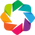

RECIPE: makeProcessedArc
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
   
   .
   PRIMITIVE: addVAR
   -----------------
   Adding the read noise component of the vari



    Extracting order 64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...



   .
   PRIMITIVE: determineWavelengthSolution
   --------------------------------------
   S20240511S0051_blue001_extracted.fits: using the XMOD from the processed_flat S20240511S0050_blue001_flat.fits (obtained from /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/dragons_for_goats2.db)
   order 64 with  6 peaks and 105 arc lines
   order 65 with 46 peaks and 97 arc lines
   order 66 with 69 peaks and 110 arc lines
   order 67 with 47 peaks and 108 arc lines
   order 68 with 56 peaks and 107 arc lines
   order 69 with 47 peaks and 101 arc lines
   order 70 with 60 peaks and 90 arc lines
   order 71 with 64 peaks and 92 arc lines
   order 72 with 59 peaks and 89 arc lines
   order 73 with 62 peaks and 90 arc lines
   order 74 with 60 peaks and 89 arc lines
   order 75 with 51 peaks and 96 arc lines
   order 76 with 48 peaks and 110 arc lines
   order 77 with 59 peaks and 108 arc lines
   order 78 with 68 peaks and 104 arc lines
   order 79 

('GS-CAL20240511-12_std_red_1_1_std', 'medium') 3


RECIPE: makeProcessedArc
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
   Using bpm_20220601_ghost_red_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_red_11_full_4amp.fits as static BPM
   
   Using bpm_20220601_ghost_red_11_full_4amp.fits as static BPM
   
   .
   PRIMITIVE: addVAR
   -----------------
   Adding the read noise component of the varianc



    Extracting order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...



   .
   PRIMITIVE: determineWavelengthSolution
   --------------------------------------
   S20240511S0051_red001_extracted.fits: using the XMOD from the processed_flat S20240511S0050_red001_flat.fits (obtained from /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/dragons_for_goats2.db)
   order 33 with 10 peaks and 26 arc lines
   order 34 with 26 peaks and 53 arc lines
   order 35 with 50 peaks and 72 arc lines
   order 36 with 61 peaks and 74 arc lines
   order 37 with 63 peaks and 86 arc lines
   order 38 with 77 peaks and 94 arc lines
   order 39 with 57 peaks and 85 arc lines
   order 40 with 48 peaks and 69 arc lines
   order 41 with 44 peaks and 63 arc lines
   order 42 with 41 peaks and 60 arc lines
   order 43 with 37 peaks and 68 arc lines
   order 44 with 47 peaks and 76 arc lines
   order 45 with 36 peaks and 84 arc lines
   order 46 with 37 peaks and 79 arc lines
   order 47 with 55 peaks and 84 arc lines
   order 48 with 59 pe

In [16]:
for K, V in DF_arc.groupby(['group_id','read_mode']):
    if "slit" in K[0] or "slit" in K[1]:
        continue
    print (K, len(V))
    dragons_reduce(list(V['file'].values), config_file=dragons_rc)

In [17]:
for F in caldb.list_files():
    print (F)

FileData(name='S20240430S0029_blue001_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/calibrations/processed_bias')
FileData(name='S20240430S0029_red001_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/calibrations/processed_bias')
FileData(name='S20240430S0029_slit_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/calibrations/processed_bias')
FileData(name='S20240501S0060_red001_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/calibrations/processed_bias')
FileData(name='S20240501S0066_blue001_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/calibrations/processed_bias')
FileData(name='S20240507S0017_blue001_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/

## Process spectrophotometric standard

In [23]:
np.unique(DF_object['object'])

array(['HIP 60985', 'HIP67523', 'V* RR Gru'], dtype=object)

**For the progCal HIP 60985, the reduction of the slit-viewer data crashes not able to find matching slit flat. This is likely because this target was observed in the high resolution mode unlike the rest of the data. Appears GOA wrongly assoicated this specphot with the data set.**

In [51]:
temp = DF_object[DF_object['object']== 'HIP 60985']
temp

,file,obs_class,group_id,exp,object,wave,waveband,date,roi,read_mode,arm
0,/Users/monika.soraisam/Desktop/tomdev/real_goa...,progCal,GS-2024A-FT-107-4_high_blue_1_4_high,120.0,HIP 60985,4.400000e-07,g,2024-05-04,Fixed,slow,blue
1,/Users/monika.soraisam/Desktop/tomdev/real_goa...,progCal,GS-2024A-FT-107-4_high_red_1_4_high,120.0,HIP 60985,7.500000e-07,i,2024-05-04,Fixed,medium,red
2,/Users/monika.soraisam/Desktop/tomdev/real_goa...,progCal,GS-2024A-FT-107-4_high_slitv_2_2_high,3.0,HIP 60985,NaN,None,2024-05-04,Fixed,standard,slitv


   All submitted files appear valid:
   /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240504S0090_slit.fits


('GS-2024A-FT-107-4_high_slitv_2_2_high', 'standard') 1


   RECIPE: makeProcessedSlit
      PRIMITIVE: prepare
      ------------------
         PRIMITIVE: validateData
         -----------------------
         .
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
         PRIMITIVE: standardizeHeaders
         -----------------------------
            PRIMITIVE: standardizeObservatoryHeaders
            ----------------------------------------
            Updating keywords that are common to all Gemini data
            .
            PRIMITIVE: standardizeInstrumentHeaders
            ---------------------------------------
            .
         .
         PRIMITIVE: standardizeWCS
         -------------------------
         .
      .
      PRIMITIVE: addDQ
      ----------------
         PRIMITIVE: addDQ
         ----------------
         No BPMs found for S20240504S0090_slit_prepared.fits and none supplied by the user.
         
         .
      .
      PRIMITIVE: addVAR
      -----------------
   

RuntimeError: Unable to find slitflat calibration for S20240504S0090_slit_CRFixed.fits

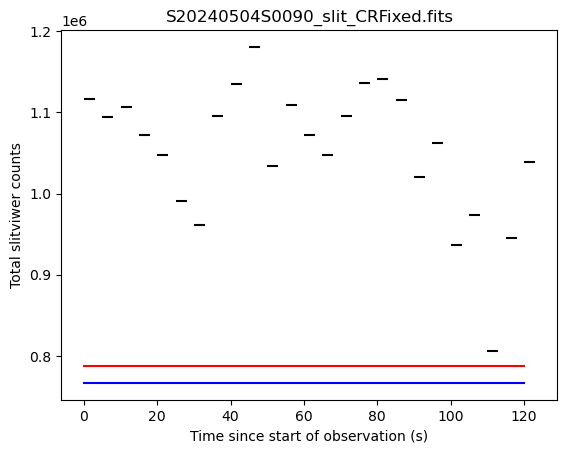

In [52]:
for K, V in temp.groupby(['group_id', 'read_mode']):
    if "slit" in K[0]:
        print (K, len(V))
        dragons_reduce(list(V['file'].values), config_file=dragons_rc)

In [68]:
ad = astrodata.open("../S20240504S0090_slit.fits")
ad.instrument(), ad.camera(), ad.filter_name(), ad.read_speed_setting(), ad.gain_setting(), ad.res_mode(), ad.focal_plane_mask(), ad.disperser()

('GHOST', 'SLITV', None, 'standard', 'standard', 'high', 'HR', None)

In [69]:
# ad = astrodata.open("S20240511S0050_slit_slitflat.fits")
# ad.instrument(), ad.camera(), ad.filter_name(), ad.read_speed_setting(), ad.gain_setting(), ad.res_mode(), ad.focal_plane_mask(), ad.disperser()

ad = astrodata.open("S20240514S0025_slit_slitflat.fits")
ad.instrument(), ad.camera(), ad.filter_name(), ad.read_speed_setting(), ad.gain_setting(), ad.res_mode(), ad.focal_plane_mask(), ad.disperser()


('GHOST', 'SLITV', None, 'standard', 'standard', 'std', 'SR', None)

In [70]:
ad = astrodata.open("../S20240529S0036_slit.fits")
ad.instrument(), ad.camera(), ad.filter_name(), ad.read_speed_setting(), ad.gain_setting(), ad.res_mode(), ad.focal_plane_mask(), ad.disperser()

('GHOST', 'SLITV', None, 'standard', 'standard', 'std', 'SR', None)

In [24]:
temp = DF_object[DF_object['object']== 'HIP67523']
temp

,file,obs_class,group_id,exp,object,wave,waveband,date,roi,read_mode,arm
6,/Users/monika.soraisam/Desktop/tomdev/real_goa...,partnerCal,GS-2024A-Q-333-16_std_blue_1_2_std,50.0,HIP67523,4.400000e-07,g,2024-05-29,Fixed,slow,blue
7,/Users/monika.soraisam/Desktop/tomdev/real_goa...,partnerCal,GS-2024A-Q-333-16_std_red_1_2_std,30.0,HIP67523,7.500000e-07,i,2024-05-29,Fixed,medium,red
8,/Users/monika.soraisam/Desktop/tomdev/real_goa...,partnerCal,GS-2024A-Q-333-16_std_slitv_2_2_std,1.0,HIP67523,NaN,None,2024-05-29,Fixed,standard,slitv


All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240529S0036_slit.fits


('GS-2024A-Q-333-16_std_slitv_2_2_std', 'standard') 1


RECIPE: makeProcessedSlit
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
      PRIMITIVE: addDQ
      ----------------
      No BPMs found for S20240529S0036_slit_prepared.fits and none supplied by the user.
      
      .
   .
   PRIMITIVE: addVAR
   -----------------
   Adding the read noise component of the variance
   .
   PRIMITIVE: biasCorrect
   -----------------

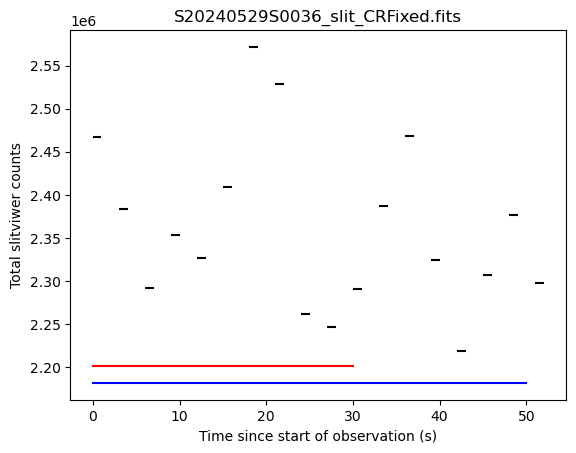

In [25]:
for K, V in temp.groupby(['group_id', 'read_mode']):
    if "slit" in K[0]:
        print (K, len(V))
        dragons_reduce(list(V['file'].values), config_file=dragons_rc)

In [27]:
for K, V in temp.groupby(['group_id', 'read_mode']):
    if "slit" in K[0]:
        continue 
    print (K, len(V))
    dragons_reduce(list(V['file'].values), uparams=[("scaleCountsToReference:tolerance",1.0)], config_file=dragons_rc)

   All submitted files appear valid:
   /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240529S0036_blue001.fits


('GS-2024A-Q-333-16_std_blue_1_2_std', 'slow') 1


   RECIPE: reduceStandard
      PRIMITIVE: prepare
      ------------------
         PRIMITIVE: validateData
         -----------------------
         .
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
         PRIMITIVE: standardizeHeaders
         -----------------------------
            PRIMITIVE: standardizeObservatoryHeaders
            ----------------------------------------
            Updating keywords that are common to all Gemini data
            .
            PRIMITIVE: standardizeInstrumentHeaders
            ---------------------------------------
            .
         .
         PRIMITIVE: standardizeWCS
         -------------------------
         .
      .
      PRIMITIVE: addDQ
      ----------------
      Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
      
      Rebinning bpm_20220601_ghost_blue_11_full_4amp.fits
      .
      PRIMITIVE: addVAR
      -----------------
      Adding the read noise component 

    Finding CRs in order 64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...

      54839 CRs found






    Extracting order 64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...



      .
      PRIMITIVE: attachWavelengthSolution
      -----------------------------------
      Arcs for S20240529S0036_blue001_extracted.fits:
         before: S20240511S0051_blue001_arc.fits
      .
      PRIMITIVE: scaleCountsToReference
      ---------------------------------
      No scaling will be performed, since at least two AstroData objects are required for scaleCountsToReference
      .
      PRIMITIVE: stackFrames
      ----------------------
      No stacking will be performed, since at least two input AstroData objects are required for stackFrames
      .
      PRIMITIVE: calculateSensitivity
      -------------------------------
      WARNING - Last message repeated 4 times
      WARNING - Cannot read spectrophotometric data table. Unable to determine sensitivity for S20240529S0036_blue001_wavelengthSolutionAttached.fits
      .
      PRIMITIVE: storeProcessedStandard
      ---------------------------------
         PRIMITIVE: storeCalibration
         ---------------

('GS-2024A-Q-333-16_std_red_1_2_std', 'medium') 1


   RECIPE: reduceStandard
      PRIMITIVE: prepare
      ------------------
         PRIMITIVE: validateData
         -----------------------
         .
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
         PRIMITIVE: standardizeHeaders
         -----------------------------
            PRIMITIVE: standardizeObservatoryHeaders
            ----------------------------------------
            Updating keywords that are common to all Gemini data
            .
            PRIMITIVE: standardizeInstrumentHeaders
            ---------------------------------------
            .
         .
         PRIMITIVE: standardizeWCS
         -------------------------
         .
      .
      PRIMITIVE: addDQ
      ----------------
      Using bpm_20220601_ghost_red_11_full_4amp.fits as static BPM
      
      Rebinning bpm_20220601_ghost_red_11_full_4amp.fits
      .
      PRIMITIVE: addVAR
      -----------------
      Adding the read noise component of

    Finding CRs in order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...

      WARNING - There are saturated pixels that have not been flagged as cosmic rays in order 64 pixel 594 (371-407)




65...

      16767 CRs found






    Extracting order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...



      .
      PRIMITIVE: attachWavelengthSolution
      -----------------------------------
      Arcs for S20240529S0036_red001_extracted.fits:
         before: S20240511S0051_red001_arc.fits
      .
      PRIMITIVE: scaleCountsToReference
      ---------------------------------
      No scaling will be performed, since at least two AstroData objects are required for scaleCountsToReference
      .
      PRIMITIVE: stackFrames
      ----------------------
      No stacking will be performed, since at least two input AstroData objects are required for stackFrames
      .
      PRIMITIVE: calculateSensitivity
      -------------------------------
      WARNING - Cannot read spectrophotometric data table. Unable to determine sensitivity for S20240529S0036_red001_wavelengthSolutionAttached.fits
      .
      PRIMITIVE: storeProcessedStandard
      ---------------------------------
         PRIMITIVE: storeCalibration
         ---------------------------
         /Users/monika.soraisam/Desk

In [28]:
for F in caldb.list_files():
    print (F)

FileData(name='S20240430S0029_blue001_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/calibrations/processed_bias')
FileData(name='S20240430S0029_red001_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/calibrations/processed_bias')
FileData(name='S20240430S0029_slit_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/calibrations/processed_bias')
FileData(name='S20240501S0060_red001_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/calibrations/processed_bias')
FileData(name='S20240501S0066_blue001_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/calibrations/processed_bias')
FileData(name='S20240507S0017_blue001_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/

## Process science

In [29]:
temp = DF_object[DF_object['object']== 'V* RR Gru']
temp

,file,obs_class,group_id,exp,object,wave,waveband,date,roi,read_mode,arm
3,/Users/monika.soraisam/Desktop/tomdev/real_goa...,science,GS-2024A-Q-414-13_std_blue_2_2_std,900.0,V* RR Gru,4.400000e-07,g,2024-05-12,Fixed,slow,blue
4,/Users/monika.soraisam/Desktop/tomdev/real_goa...,science,GS-2024A-Q-414-13_std_red_2_2_std,900.0,V* RR Gru,7.500000e-07,i,2024-05-12,Fixed,medium,red
5,/Users/monika.soraisam/Desktop/tomdev/real_goa...,science,GS-2024A-Q-414-13_std_slitv_2_2_std,23.0,V* RR Gru,NaN,None,2024-05-12,Fixed,standard,slitv


   All submitted files appear valid:
   /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240512S0136_slit.fits


('GS-2024A-Q-414-13_std_slitv_2_2_std', 'standard') 1


   RECIPE: makeProcessedSlit
      PRIMITIVE: prepare
      ------------------
         PRIMITIVE: validateData
         -----------------------
         .
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
         PRIMITIVE: standardizeHeaders
         -----------------------------
            PRIMITIVE: standardizeObservatoryHeaders
            ----------------------------------------
            Updating keywords that are common to all Gemini data
            .
            PRIMITIVE: standardizeInstrumentHeaders
            ---------------------------------------
            .
         .
         PRIMITIVE: standardizeWCS
         -------------------------
         .
      .
      PRIMITIVE: addDQ
      ----------------
         PRIMITIVE: addDQ
         ----------------
         No BPMs found for S20240512S0136_slit_prepared.fits and none supplied by the user.
         
         .
      .
      PRIMITIVE: addVAR
      -----------------
   

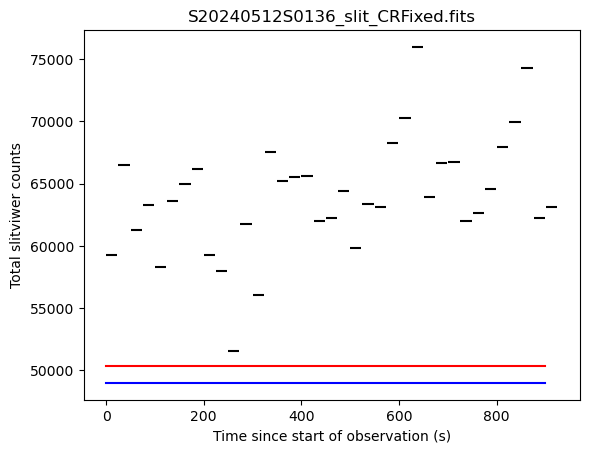

In [31]:
for K, V in temp.groupby(['group_id', 'read_mode']):
    if "slit" in K[0]:
        print (K, len(V))
        dragons_reduce(list(V['file'].values), config_file=dragons_rc)

In [33]:
for K, V in temp.groupby(['group_id', 'read_mode']):
    if "slit" in K[0]:
        continue 
    print (K, len(V))
    dragons_reduce(list(V['file'].values), config_file=dragons_rc)

   All submitted files appear valid:
   /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/S20240512S0136_blue001.fits


('GS-2024A-Q-414-13_std_blue_2_2_std', 'slow') 1


   RECIPE: reduceScience
      PRIMITIVE: prepare
      ------------------
         PRIMITIVE: validateData
         -----------------------
         .
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
         PRIMITIVE: standardizeHeaders
         -----------------------------
            PRIMITIVE: standardizeObservatoryHeaders
            ----------------------------------------
            Updating keywords that are common to all Gemini data
            .
            PRIMITIVE: standardizeInstrumentHeaders
            ---------------------------------------
            .
         .
         PRIMITIVE: standardizeWCS
         -------------------------
         .
      .
      PRIMITIVE: addDQ
      ----------------
      Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
      
      Rebinning bpm_20220601_ghost_blue_11_full_4amp.fits
      .
      PRIMITIVE: addVAR
      -----------------
      Adding the read noise component o

    Finding CRs in order 64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...

      1492 CRs found






    Extracting order 64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...



      .
      PRIMITIVE: attachWavelengthSolution
      -----------------------------------
      Arcs for S20240512S0136_blue001_extracted.fits:
         before: S20240511S0051_blue001_arc.fits
      .
      PRIMITIVE: fluxCalibrate
      ------------------------
      S20240512S0136_blue001_wavelengthSolutionAttached.fits: using the standard S20240529S0036_blue001_standard.fits (obtained from /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/dragons_for_goats2.db)
      WARNING - S20240529S0036_blue001_standard.fits has no SENSFUNC table - continuing
      .
      PRIMITIVE: barycentricCorrect
      -----------------------------
      Computing SkyCoord for 324.51486249999994, -44.68669444444444
      Applying radial velocity correction of 25.761437157712283 km/s to S20240512S0136_blue001_wavelengthSolutionAttached.fits
      .
      PRIMITIVE: storeProcessedScience
      --------------------------------
      .
      PRIMITIVE: combineOrde

('GS-2024A-Q-414-13_std_red_2_2_std', 'medium') 1


   RECIPE: reduceScience
      PRIMITIVE: prepare
      ------------------
         PRIMITIVE: validateData
         -----------------------
         .
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
         PRIMITIVE: standardizeHeaders
         -----------------------------
            PRIMITIVE: standardizeObservatoryHeaders
            ----------------------------------------
            Updating keywords that are common to all Gemini data
            .
            PRIMITIVE: standardizeInstrumentHeaders
            ---------------------------------------
            .
         .
         PRIMITIVE: standardizeWCS
         -------------------------
         .
      .
      PRIMITIVE: addDQ
      ----------------
      Using bpm_20220601_ghost_red_11_full_4amp.fits as static BPM
      
      Rebinning bpm_20220601_ghost_red_11_full_4amp.fits
      .
      PRIMITIVE: addVAR
      -----------------
      Adding the read noise component of 

    Finding CRs in order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...

      WARNING - There are saturated pixels that have not been flagged as cosmic rays in order 50 pixel 1804 (1161-1198)




51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...

      2327 CRs found






    Extracting order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...



      .
      PRIMITIVE: attachWavelengthSolution
      -----------------------------------
      Arcs for S20240512S0136_red001_extracted.fits:
         before: S20240511S0051_red001_arc.fits
      .
      PRIMITIVE: fluxCalibrate
      ------------------------
      S20240512S0136_red001_wavelengthSolutionAttached.fits: using the standard S20240529S0036_red001_standard.fits (obtained from /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ghost/GS-2024A-Q-414-13/reduction/dragons_for_goats2.db)
      WARNING - S20240529S0036_red001_standard.fits has no SENSFUNC table - continuing
      .
      PRIMITIVE: barycentricCorrect
      -----------------------------
      Computing SkyCoord for 324.51486249999994, -44.68669444444444
      Applying radial velocity correction of 25.761437157712283 km/s to S20240512S0136_red001_wavelengthSolutionAttached.fits
      .
      PRIMITIVE: storeProcessedScience
      --------------------------------
      .
      PRIMITIVE: combineOrders
   

In [71]:
# Let's plot the extracted 1D science spectrum 
ad = astrodata.open("S20240512S0136_red001_dragons.fits")
ad.info()

Filename: S20240512S0136_red001_dragons.fits
Tags: EXTRACTED GEMINI GHOST OVERSCAN_SUBTRACTED OVERSCAN_TRIMMED PREPARED
    PROCESSED PROCESSED_SCIENCE RED SIDEREAL SOUTH SPECT XD

Pixels Extensions
Index  Content                  Type              Dimensions     Format
[ 0]   science                  NDAstroData       (67308,)       float32
          .variance             ADVarianceUncerta (67308,)       float32
          .mask                 ndarray           (67308,)       uint16
[ 1]   science                  NDAstroData       (67308,)       float32
          .variance             ADVarianceUncerta (67308,)       float32
          .mask                 ndarray           (67308,)       uint16

Other Extensions
               Type        Dimensions
.HISTORY       Table       (19, 4)
.PROVENANCE    Table       (7, 4)


In [72]:
from gempy.adlibrary import plotting

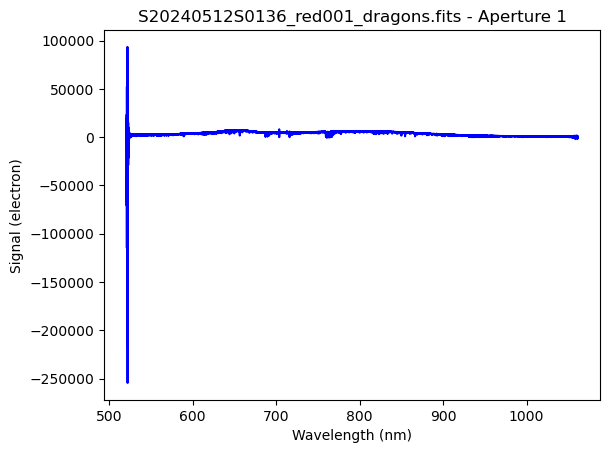

In [73]:

plt.ioff()
plotting.dgsplot_matplotlib(ad, 1)
plt.ion()
